In [1]:
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers.convolutional import Convolution2D
from keras import backend as K
import keras
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from img_loader import DatasetLoader
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from sklearn.preprocessing import MinMaxScaler
import scipy.misc
from PIL import ImageEnhance
import cv2

Using TensorFlow backend.


In [2]:
%matplotlib inline

# STEP ONE -> Create a CAM compatible VGG16 version

In [3]:
batch_size = 10
epochs = 5

In [4]:
dataset_loader = DatasetLoader('dataset_mini', 10000)
_, x_train, y_train = dataset_loader.load_dataset()

print(x_train.shape)

x_train = x_train.astype('float64')

x_train = preprocess_input(x_train)
print(x_train.shape)

y_train = np_utils.to_categorical(y_train, dataset_loader.nb_classes)

DATASET LOADER] Discovering dataset...
DATASET LOADER] 
2 classes found.
 4 images found.
DATASET LOADER] Shuffling order...
DATASET LOADER] 
Ready for loading!
 3 for training and 1 for testing
DATASET LOADER] Loaded all imgs for training. Next call will load test data...
DATASET LOADER] Loading completed!
(3, 256, 256, 3)
(3, 256, 256, 3)


In [5]:
model = Sequential(applications.VGG16(weights='imagenet', include_top=False).layers)

# last conv for having only one inbound node
model.add(Convolution2D(512, 3, 3, activation='relu', border_mode="same", name="CAM"))
model.add(GlobalAveragePooling2D(name="GAP"))
model.add(Dense(dataset_loader.nb_classes, activation='softmax', name='W'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu", name="CAM", padding="same")`


In [6]:
#train 
for i in range(0, epochs):
    model.fit(x_train, y_train, batch_size=10, epochs=1, verbose=0)
print('Training done!')

Training done!


In [7]:
_, x_test, y_test = dataset_loader.load_dataset()

print(x_test.shape)

x_test = x_test.astype('float64')

x_test = preprocess_input(x_test)
print(x_test.shape)

y_test = np_utils.to_categorical(y_test, dataset_loader.nb_classes)
model.evaluate(x_test, y_test, batch_size=10, verbose=0)

DATASET LOADER] Loaded all imgs for test. Done! Next call will load train data
DATASET LOADER] Loading completed!
(1, 256, 256, 3)
(1, 256, 256, 3)


[16.118095397949219, 0.0]

# STEP TWO -> Define a k.function like generator

In [8]:
# Pre-process input
input_img = x_train[2]
input_img = np.expand_dims(input_img, axis=0)
input_img.shape

(1, 256, 256, 3)

In [9]:
#Verify layer output 
print('inbound', model.get_layer('CAM').output.shape)

inbound (?, ?, ?, 512)


In [10]:
def get_outputs_generator(model, layer_name):
    """
    Gets the output generator of a specific layer of the model.

    :param model: The model
    :param layer_name: The layer's name
    :return: the output generator (a function)
    """
    layer_model = Model(
        input=model.input,
        output=model.get_layer(layer_name).output
    )

    return layer_model.predict

In [11]:
output_generator = get_outputs_generator(model, 'CAM')
layer_outputs = output_generator(input_img)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


In [12]:
print(layer_outputs[0])

[[[  0.00000000e+00   2.47605880e+07   0.00000000e+00 ...,   7.44059200e+07
     0.00000000e+00   2.90555720e+07]
  [  0.00000000e+00   4.95950040e+07   0.00000000e+00 ...,   1.13609976e+08
     0.00000000e+00   4.15610880e+07]
  [  0.00000000e+00   5.88267640e+07   0.00000000e+00 ...,   1.27095896e+08
     0.00000000e+00   4.58666240e+07]
  ..., 
  [  0.00000000e+00   5.81547160e+07   0.00000000e+00 ...,   1.22336408e+08
     0.00000000e+00   4.47697200e+07]
  [  0.00000000e+00   5.04260880e+07   0.00000000e+00 ...,   1.03596032e+08
     0.00000000e+00   3.90501880e+07]
  [  0.00000000e+00   3.35049480e+07   0.00000000e+00 ...,   5.88189320e+07
     0.00000000e+00   2.40961080e+07]]

 [[  0.00000000e+00   4.91628320e+07   0.00000000e+00 ...,   1.09754688e+08
     0.00000000e+00   4.44552200e+07]
  [  0.00000000e+00   9.78769440e+07   0.00000000e+00 ...,   1.74116160e+08
     0.00000000e+00   6.42609760e+07]
  [  0.00000000e+00   1.15660904e+08   0.00000000e+00 ...,   1.95678112e+08
  

In [13]:
#Grab the output of the layer:
output_generator = get_outputs_generator(model, 'CAM')
layer_outputs = output_generator(input_img)[0]
print('layer output shape',layer_outputs.shape)
img = layer_outputs[:, :, 0]
print('image shape', img.shape)
print('number of filters:', layer_outputs.shape[2])

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


layer output shape (8, 8, 512)
image shape (8, 8)
number of filters: 512


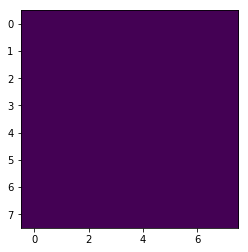

In [14]:
plt.imshow(img)

In [15]:
print('GAP layer shape', model.get_layer('GAP').output.shape)
print('layer w shape', np.asarray(model.get_layer("W").get_weights()).shape)
print('layer w shape[0]', model.get_layer("W").get_weights()[0].shape)
print('layer w[0]', model.get_layer("W").get_weights()[0])

GAP layer shape (?, 512)
layer w shape (2,)
layer w shape[0] (512, 2)
layer w[0] [[ 0.02082226  0.03578893]
 [-0.04513262 -0.10772339]
 [-0.10309819  0.02312392]
 ..., 
 [-0.00444397 -0.09785925]
 [-0.03044327 -0.00657404]
 [-0.00569641 -0.05023158]]


So as we see here the weights that we need are as model.get_layer("W").get_weights()[0][k_kernel][class_to_predict]

In [16]:
def reduce_opacity(im, opacity):
    """
    Returns an image with reduced opacity.
    Taken from http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/362879
    """
    assert 0 <= opacity <= 1
    if im.mode != 'RGBA':
        im = im.convert('RGBA')
    else:
        im = im.copy()
    alpha = im.split()[3]
    alpha = ImageEnhance.Brightness(alpha).enhance(opacity)
    im.putalpha(alpha)
    return im

In [21]:
def heatmap_generate(input_img, model, class_to_predict, layer_name, image_name=None):
   
    output_generator = get_outputs_generator(model, layer_name)
    layer_outputs = output_generator(np.expand_dims(input_img, axis=0))[0]
    heatmap = Image.new("RGBA", (224, 224), color=0)
    # Normalize input on weights
    w = MinMaxScaler((0.0, 1.0)).fit_transform(model.get_layer("W").get_weights()[0])

    for z in range(0, layer_outputs.shape[2]): # Iterate through the number of kernels
        img = layer_outputs[:, :, z]

        deprocessed = scipy.misc.toimage(cv2.resize(img, (224, 224))).convert("RGBA")
        deprocessed = reduce_opacity(deprocessed, w[z][class_to_predict])
        heatmap.paste(deprocessed, (0, 0), deprocessed)
    # heatmap = image.img_to_array(ImageOps.invert(heatmap.convert("RGB")).convert("RGBA"))
    # ImageOps.invert(heatmap.convert("RGB")).convert("RGBA").save("TMP.png", "PNG")
    heatmap.save("TMP.png", "PNG")
    heatmap = cv2.imread("TMP.png", cv2.CV_8UC3)  # FIXME: remove tmp file
    
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * np.asarray(heatmap)), cv2.COLORMAP_JET)
    heatmap_colored[np.where(heatmap <= 0.2)] = 0

    if image_name is not None:
        heatmap_colored = cv2.putText(heatmap_colored, image_name, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0),
                                      2)
    return Image.fromarray(cv2.resize(heatmap_colored, (224, 224)))

In [22]:
input_img = x_train[2]
img = heatmap_generate(input_img, model, 0, 'CAM', image_name='test')


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


In [1]:
img.show()

NameError: name 'img' is not defined

In [20]:
w = MinMaxScaler((0.0, 1.0)).fit_transform(model.get_layer("W").get_weights()[0])
print(w)
print(w[0])
print(w[0][0])

[[ 0.58274531  0.68033141]
 [ 0.27614558  0.01419902]
 [ 0.00668514  0.62154502]
 ..., 
 [ 0.46529201  0.0599848 ]
 [ 0.34443092  0.4836978 ]
 [ 0.45946985  0.28105527]]
[ 0.58274531  0.68033141]
0.582745
